<a href="https://colab.research.google.com/github/mattiasthalen/Bayesian-Velocity-Profiling/blob/main/Bayesian_Velocity_Profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Velocity Profiling

## Setup Environment


### Install Libraries

In [1]:
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade pymc
!pip install --upgrade numpyro
!pip install --upgrade blackjax
!pip install --upgrade pint_xarray
!pip install --upgrade bottleneck
!pip install --upgrade numbagg
!pip install --upgrade ipython-autotime
!pip install --upgrade netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 2.1 MB/s 
     |████████████████████████████████| 128 kB 14.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 3.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 355 kB 2.1 MB/s 
Looking in indexes: h

### Setup Platform

In [2]:
import numpyro
import jax
import jax.tools.colab_tpu

try:
    
    jax.tools.colab_tpu.setup_tpu()
    numpyro.util.set_platform('tpu')

    print('TPU assigned.')
    display(jax.local_devices())

except:
    print('No TPU available, trying GPU.')
    
    try:
        numpyro.set_platform('gpu')
        print('GPU assigned.')
        display(jax.local_devices())

    except:
        numpyro.set_platform('cpu')
        print('No GPU available, using CPU.')
        display(jax.local_devices())

No TPU available, trying GPU.
GPU assigned.
No GPU available, using CPU.


[CpuDevice(id=0)]

### Load Libraries

In [3]:
%load_ext autotime

time: 684 µs (started: 2022-09-28 06:47:36 +00:00)


In [4]:
import pymc as pm
import pymc.sampling_jax

time: 4.81 s (started: 2022-09-28 06:47:36 +00:00)


/usr/local/lib/python3.7/dist-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [5]:
import time
import pint_xarray
import warnings

import requests
import numpyro
import sklearn.preprocessing
import sklearn.metrics

import pandas as pd
import numpy as np
import arviz as az
import xarray as xr

from jax import numpy as jnp
from numpyro import distributions as dist

from collections import OrderedDict
from google.colab import drive
from requests import get
from urllib.parse import unquote

from requests import get
from urllib.parse import unquote
from matplotlib import pyplot as plt

from typing import Callable, Optional, Dict, List, Union, NoReturn

time: 415 ms (started: 2022-09-28 06:47:40 +00:00)


### Set Global Vars

In [6]:
#rng_key = jax.random.PRNGKey(33)
n_devices = np.max([2, len(jax.local_devices())])
numpyro.set_host_device_count(n_devices)

time: 1.2 ms (started: 2022-09-28 06:47:41 +00:00)


In [7]:
plt.style.use('bmh')

time: 2.21 ms (started: 2022-09-28 06:47:41 +00:00)


In [8]:
csv_path = 'https://raw.githubusercontent.com/mattiasthalen/Bayesian-Velocity-Profiling/main/RepOne_Data_Export.csv'

time: 471 µs (started: 2022-09-28 06:47:41 +00:00)


## Functions

### Regression Functions

In [9]:
def calc_obs_weight(mvt, velocity, weight, max_weight):
    try:
        mvt = mvt.pint.dequantify()
        velocity = velocity.pint.dequantify()
        weight = weight.pint.dequantify()
        max_weight = max_weight.pint.dequantify()
    except:
        pass
    finally:
        obs_weight = 0.5**((1 - mvt/velocity)/0.2) * 0.5**((1 - weight/max_weight)/0.2)
        
    return obs_weight

time: 1.37 ms (started: 2022-09-28 06:47:41 +00:00)


In [10]:
def linear_fn(x, intercept, slope):
    return intercept + slope*x

def linear_rev_fn(x, intercept, slope):
    return (x - intercept)/slope

def linear_fit(ds, var, coord, reduce_dims):
    ds = ds.where((ds.coords['set_type'] != 'Back Off') & (ds['workup_sets'] > 2), drop = True)\
              .sel({'aggregation': 'max'}, drop = True)\
              .pint.dequantify()

    coefs = ds[var].curvefit(coords = ds[coord],
                             func = linear_fn,
                             reduce_dims = reduce_dims)\
                   .rename({'param': 'regression_param'})
    
    return coefs['curvefit_coefficients']

def linear_predict(x, coefs, reverse = False):
    intercept = coefs.sel(regression_param = 'intercept', drop = True)
    slope = coefs.sel(regression_param = 'slope', drop = True)

    if reverse:
            return linear_rev_fn(x, intercept, slope)

    return linear_fn(x, intercept, slope)

time: 4.27 ms (started: 2022-09-28 06:47:41 +00:00)


### Plotting Functions

In [11]:
def plot_pbc(ds, exercise, data_var, window = 20, signal_window = 8, ax = None):
    df = ds[data_var].sel({'exercise': exercise}, drop = True)\
                     .drop_vars(['training_cycle', 'cycle_type', 'max_weight_pr_flag'])\
                     .to_dataframe()\
                     .dropna()
    
    df['moving_average'] = df[data_var].sort_index(ascending = False)\
                                       .rolling(window, min_periods = 1)\
                                       .mean()
    
    df['moving_range'] = df[data_var].diff(-1)\
                                     .abs()\
                                     .sort_index(ascending = False)\
                                     .rolling(window, min_periods = 1)\
                                     .mean()

    df['process_average'] = df['moving_average']
    df['process_range'] = df['moving_range']
    df['signal'] = None
    df['signal_min'] = None
    df['signal_max'] = None
    df['signal_above_average'] = None
    df['signal_below_average'] = None

    n_rows = len(df)
    previous_signal_id = 0

    for row in np.arange(n_rows):
        first_row = row == 0
        sufficient_rows_left = n_rows - row >= window

        signal_start_id = np.max([8, row - signal_window])

        df['signal_min'][row] = df[data_var][signal_start_id:row].min()
        df['signal_max'][row] = df[data_var][signal_start_id:row].max()

        df['signal_above_average'][row] = (df['signal_min'][row] > df['process_average'][row - 1])
        df['signal_below_average'][row] = (df['signal_max'][row] < df['process_average'][row - 1])

        signal_open = (first_row) | (row >= previous_signal_id + window)
        signal = (signal_open) & (sufficient_rows_left) & (first_row | df['signal_above_average'][row] | df['signal_below_average'][row])
        df['signal'][row] = signal
        
        df['process_average'][row] =  df['process_average'][row - 1]
        df['process_range'][row] =  df['process_range'][row - 1]

        if signal:
            previous_signal_id = row
            df['process_average'][row] =  df['moving_average'][row]
            df['process_range'][row] =  df['moving_range'][row]
        else:
            df['process_average'][row] =  df['process_average'][row - 1]
            df['process_range'][row] =  df['process_range'][row - 1]

    df['lower_limit_1'] = df['process_average'] - df['process_range']/1.128
    df['upper_limit_1'] = df['process_average'] + df['process_range']/1.128
    df['lower_limit_2'] = df['process_average'] - df['process_range']*2/1.128
    df['upper_limit_2'] = df['process_average'] + df['process_range']*2/1.128
    df['lower_limit_3'] = df['process_average'] - df['process_range']*3/1.128
    df['upper_limit_3'] = df['process_average'] + df['process_range']*3/1.128

    if ax is None:
        ax = plt.gca()

    ax.scatter(df.index, df[data_var], marker = '.', alpha = 0.6)
    ax.plot(df.index, df['process_average'])
    ax.plot(df.index, df['lower_limit_3'])
    ax.plot(df.index, df['upper_limit_3'])

    ax.fill_between(df.index,df['lower_limit_1'], df['upper_limit_1'], alpha = 0.3)

    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_ylim([0, None])
    ax.tick_params(labelrotation = 90)
    ax.grid()

    return ax

time: 160 ms (started: 2022-09-28 06:47:41 +00:00)


In [12]:
def plot_kpis(ds, exercise, vars):
    var_titles = [var.title().replace('_', ' ').replace('1Rm', '1RM') for var in vars]

    n_vars = len(vars)

    n_cols = 1

    if n_vars > 1:
        n_cols = 2
    
    n_rows = 1

    if n_vars > 2:
        n_rows = np.ceil(n_vars/n_cols).astype(int)
    
    figsize = np.array([6, 3]) * [n_cols, n_rows]

    fig, axes = plt.subplots(ncols = n_cols,
                            nrows = n_rows,
                            constrained_layout = True,
                            figsize = figsize,
                            sharex = True)
    
    axes = [ax for row in axes for ax in row]

    for key, val in enumerate(vars):
        plot_pbc(ds, exercise, vars[key], ax = axes[key])
        title = var_titles[key]
        axes[key].set_title(title)

    fig.suptitle(f'{exercise.title()} KPIs', fontsize = 16)
    fig.supxlabel('Workout Start Time')

    plt.draw()

time: 5.68 ms (started: 2022-09-28 06:47:41 +00:00)


### ETL Functions

In [13]:
def new_extract(csv_path, ds_path, **kwargs):
    try:
        return os.path.getmtime(csv_path) > os.path.getmtime(ds_path)
    except:
        return True

time: 1.2 ms (started: 2022-09-28 06:47:41 +00:00)


In [14]:
def extract_data(csv_path, **kwargs):
    df = pd.read_csv(csv_path)

    df.columns = (df.columns
                    .str.lower()
                    .str.replace(' \(m/s\)', '')
                    .str.replace(' \(mm\)', '')
                    .str.replace(' \(sec\)', '')
                    .str.replace(' \(%\)', '')
                    .str.replace(' ', '_'))
    
    df.rename(columns = {'weight': 'load'}, inplace = True)

    df['workout_start_time'] = pd.to_datetime(df['workout_start_time'], format = '%d/%m/%Y, %H:%M:%S')

    df.dropna(subset = ['exercise'], inplace = True)
    df['rest_time'] = pd.to_timedelta(df['rest_time'])

    # Correct split session
    df['set'].mask((df['exercise'] == 'deadlift') & (df['workout_start_time'] == pd.to_datetime('2020-12-30 13:06:04')), df['set'] + 7, inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2020-12-30 13:06:04')}, pd.to_datetime('2020-12-30 12:53:09'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-01-07 11:50:22')}, pd.to_datetime('2021-01-07 11:20:07'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-06-10 12:02:22')}, pd.to_datetime('2021-06-10 11:56:31'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-06-14 12:06:00')}, pd.to_datetime('2021-06-14 11:57:50'), inplace = True)

    # Reindex sets & reps to counter bugs in the extract
    df['set'] = df.groupby(['exercise', 'workout_start_time'])['set'].apply(lambda x: (x != x.shift()).cumsum() - 1)
    df['rep'] = df.groupby(['exercise', 'workout_start_time', 'set']).cumcount()

    # Convert from , to . as decimal sign
    df['load'] = df['load'].str.replace(',', '.').astype('float')

    # Drop rows with tag fail
    fail_filter = df['tags'].str.contains('fail', na = False)
    df = df[~fail_filter]

    # Handle the case when a rep is split into two reps
    rep_split_filter = df['tags'].str.contains('rep split', na = False)

    rep_split_df = df[rep_split_filter].groupby(['exercise', 'workout_start_time', 'set', 'load', 'metric'])[['range_of_motion', 'duration_of_rep']].sum()
    rep_split_df['avg_velocity'] = rep_split_df['range_of_motion']/1000/rep_split_df['duration_of_rep']
    rep_split_df['rep'] = 0
    rep_split_df.reset_index(inplace = True)

    rep_split_df = rep_split_df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

    df = pd.concat([df[~rep_split_filter], rep_split_df])

    # Group to get multi index
    df = df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

    return df

time: 8.44 ms (started: 2022-09-28 06:47:41 +00:00)


In [15]:
def define_cycles(cycles, min_workout_start_time, **kwargs):
    cycle_start_dates = np.array(list(cycles.keys())).astype('datetime64[ns]')

    if min_workout_start_time < cycle_start_dates.min():
        cycles = {min_workout_start_time.strftime('%Y-%m-%d'): 'n/a', **cycles}
        cycle_start_dates = np.array(list(cycles.keys())).astype('datetime64[ns]')

    cycle_types = np.array(list(cycles.values()))
    cycle_id = np.arange(len(cycle_start_dates))

    ds = xr.Dataset(coords = {'workout_start_time': cycle_start_dates,
                              'training_cycle': ('workout_start_time', cycle_id),
                              'cycle_type': ('workout_start_time', cycle_types)})

    return ds

time: 8.65 ms (started: 2022-09-28 06:47:41 +00:00)


In [16]:
def transform_data(df, **kwargs):
    # Convert to xarray
    ds = df.to_xarray()

    # Change Set and Rep to integers
    ds['set'] = ds['set'].astype(int)
    ds['rep'] = ds['rep'].astype(int)

    # Move variables to coords
    ds = ds.set_coords(['metric', 'tags'])

    # Define UOMs
    ds = ds.pint.quantify({'load': 'kg',
                           'avg_velocity': 'meter / second',
                           'peak_velocity': 'meter / seconds',
                           'range_of_motion': 'mm',
                           'duration_of_rep': 's'})

    # Session meta data
    session_stack = ['exercise', 'workout_start_time']
    ds['session_max_load'] = ds['load'].stack(stack = session_stack)\
                                       .groupby('stack')\
                                       .reduce(all_nan_max, ...)\
                                       .unstack()

    # Set meta data
    set_stack = ['exercise', 'workout_start_time', 'set']
    ds['load'] = (ds['load'].stack(stack = set_stack)
                            .groupby('stack')
                            .reduce(all_nan_max, ...)
                            .unstack())

    ds['reps'] = (ds['avg_velocity'].stack(stack = set_stack)
                                    .groupby('stack')
                                    .count(...)
                                    .unstack()
                                    .where(ds['load'] > 0, drop = True))

    ds['set_velocities'] = summarize(ds['avg_velocity'].pint.dequantify())
    ds['set_velocities'] = ds['set_velocities'].pint.quantify({ds['set_velocities'].name: 'mps'})

    ds.coords['set_type'] = assign_set_type(ds['load'])

    # Merge training cycle coordinates
    cycles = define_cycles(**kwargs)
    ds = ds.merge(cycles, join = 'outer')
    ds['cycle_type'] = ('workout_start_time', ds['cycle_type'].to_series().ffill())
    ds['training_cycle'] = ds['training_cycle'].ffill('workout_start_time').astype(int)

    # Add the running min top set velocity per exercise
    ds['minimum_velocity_threshold'] = (ds['set_velocities'].sel({'aggregation': 'first'})
                                                            .where(ds.coords['set_type'] == 'Top Set')
                                                            .pint.dequantify()
                                                            .stack(stack = ['exercise', 'workout_start_time'])
                                                            .groupby('stack')
                                                            .reduce(all_nan_min, ...)
                                                            .unstack()
                                                            .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                                    min_periods = 1)
                                                            .min())
    ds['minimum_velocity_threshold'] = ds['minimum_velocity_threshold'].pint.quantify({ds['minimum_velocity_threshold'].name: 'meter / second'})

    # Add running max load per exercise
    ds['rolling_max_load'] = (ds['load'].pint.dequantify()
                                             .stack(stack = ['exercise', 'workout_start_time'])
                                             .groupby('stack')
                                             .reduce(all_nan_max, ...)
                                             .unstack()
                                             .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                      min_periods = 1)
                                             .max())
    ds['rolling_max_load'] = ds['rolling_max_load'].pint.quantify({ds['rolling_max_load'].name: 'kg'})

    # Generate the observation weights
    ds['observation_weight'] = calc_obs_weight(ds['minimum_velocity_threshold'], ds['set_velocities'], ds['load'], ds['session_max_load'])

    # Additional session meta data
    ds['workup_sets'] = ds['load'].where(ds.coords['set_type'] == 'Work Up', drop = True)\
                                  .stack(stack = session_stack)\
                                  .groupby('stack')\
                                  .count(...)\
                                  .unstack()
    
    ds['session_regression_coefficients'] = linear_fit(ds, 'load', 'set_velocities', 'set')

    ds['estimated_1rm'] = linear_predict(ds['minimum_velocity_threshold'].pint.dequantify(), ds['session_regression_coefficients'])
    ds['estimated_1rm'] = ds['estimated_1rm'].pint.quantify({ds['estimated_1rm'].name: 'kg'})

    ds['zero_velocity_load'] = linear_predict(0, ds['session_regression_coefficients'])
    ds['zero_velocity_load'] = ds['zero_velocity_load'].pint.quantify({ds['zero_velocity_load'].name: 'kg'})

    ds['zero_load_velocity'] = linear_predict(0, ds['session_regression_coefficients'], reverse = True)
    ds['zero_load_velocity'] = ds['zero_load_velocity'].pint.quantify({ds['zero_load_velocity'].name: 'mps'})

    ds['curve_score'] = ds['zero_velocity_load'].pint.dequantify()*ds['zero_load_velocity'].pint.dequantify()/2

    ds['session_volume'] = (ds['load'] * ds['reps']).stack(stack = session_stack).groupby('stack').sum(...).unstack()
    ds['session_relative_volume'] = ds['session_volume']/ds['estimated_1rm']

    # Rep meta data
    ds['rep_exertion'] = linear_predict(ds['avg_velocity'].pint.dequantify(), ds['session_regression_coefficients'])/ds['estimated_1rm'].pint.dequantify()
    ds['rep_force'] = (ds['load']*ds['range_of_motion'].pint.to('meter')/ds['duration_of_rep']**2).pint.to('N')
    ds['rep_energy'] = (ds['rep_force']*ds['range_of_motion'].pint.to('meter')).pint.to('J')

    # Session meta data
    ds['session_exertion_load'] = ds['rep_exertion'].stack(stack = ['exercise', 'workout_start_time']).groupby('stack').reduce(all_nan_sum, ...).unstack().pint.dequantify()

    # Add PR coordinates
    ds.coords['max_load_pr_flag'] = ds['rolling_max_load'].diff('workout_start_time') > 0

    return ds

time: 15.2 ms (started: 2022-09-28 06:47:41 +00:00)


In [17]:
def etl_data(**kwargs):
    df = extract_data(**kwargs)

    min_workout_start_time = df.index.get_level_values('workout_start_time').min().floor('D')

    ds = transform_data(df, min_workout_start_time = min_workout_start_time, **kwargs)

    return ds
    
    try:
        os.remove(ds_path)
    except:
        pass

    try:
        ds.to_netcdf(ds_path)
    except PermissionError:
        print('PermissionError')    

    return ds   

time: 1.41 ms (started: 2022-09-28 06:47:41 +00:00)


In [18]:
def get_data(**kwargs):
    #if not new_extract(**kwargs):
    #    return xr.open_dataset(kwargs['ds_path'])
    
    return etl_data(**kwargs)

time: 1.12 ms (started: 2022-09-28 06:47:41 +00:00)


### Miscellaneous Functions

In [19]:
def assign_set_type(da):
    set_category = xr.where(da['set'] < da.idxmax('set'), 'Work Up', np.nan)
    set_category = xr.where(da['set'] == da.idxmax('set'), 'Top Set', set_category)
    set_category = xr.where(da['set'] > da.idxmax('set'), 'Back Off', set_category)
    set_category = xr.where(np.isnan(da), np.nan, set_category)
    
    return set_category

time: 2.48 ms (started: 2022-09-28 06:47:41 +00:00)


In [20]:
def agg_summarize(x):
    x = x[np.isfinite(x)]

    if len(x) > 0:
        min = np.min(x)
        max = np.max(x)
        first = x[0]
        last = x[-1]
        peak_end = np.mean([min, last])
        mean = np.mean(x)
        median = np.median(x)
        hdi = az.hdi(x)
        result = np.array([min, max, first, last, peak_end, mean, median, *hdi])
    else:
        result = np.array([np.nan]*9)
    
    return result

def summarize(x, reduce_dim = 'rep'):
    summaries = xr.apply_ufunc(agg_summarize,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['aggregation']])
    
    summaries['aggregation'] = ['min', 'max', 'first', 'last', 'peak_end', 'mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

time: 9.72 ms (started: 2022-09-28 06:47:41 +00:00)


In [21]:
def agg_hdi_summary(x):
    mean = x.mean()
    median = np.median(x)
    hdi = az.hdi(x)

    return np.array([mean, median, *hdi])

def hdi_summary(x, reduce_dim = 'sample'):
    try:
        x = x.pint.dequantify()
    except:
        pass

    summaries = xr.apply_ufunc(agg_hdi_summary,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['hdi_aggregation']])
    
    summaries['hdi_aggregation'] = ['mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

time: 2.59 ms (started: 2022-09-28 06:47:41 +00:00)


In [22]:
def all_nan_summary(x, mode = 'mean', **kwargs):
    if np.all(np.isnan(x)):
        return np.nan
    elif mode == 'max':
        return np.nanmax(x)
    elif mode == 'min':
        return np.nanmin(x)
    elif mode == 'mean':
        return np.nanmean(x)
    elif mode == 'sum':
        return np.nansum(x)
        
def all_nan_max(x, **kwargs):
    return all_nan_summary(x, 'max', **kwargs)
        
def all_nan_min(x, **kwargs):
    return all_nan_summary(x, 'min', **kwargs)
        
def all_nan_mean(x, **kwargs):
    return all_nan_summary(x, 'mean', **kwargs)
        
def all_nan_sum(x, **kwargs):
    return all_nan_summary(x, 'sum', **kwargs)

time: 5.94 ms (started: 2022-09-28 06:47:41 +00:00)


In [23]:
def profile(data, exercise, ds, mvt = None, plot = True, use_weights = True, **kwargs):
    tic = time.perf_counter()

    data = np.array(list(data.items()))
    
    load = data[:, 0]
    velocity = data[:, 1]
    
    # Set minimum velocity threshold
    if mvt is None:        
        try:
            mvt = ds['minimum_velocity_threshold'].sel({'exercise': exercise.lower()})[-1]
        except:
            mvt = mvt.mean()

        try:
            mvt = mvt.pint.dequantify().item()
        except:
            mvt = mvt.item()
    
    mvt = np.nanmin([mvt, velocity.min()])

    # Max load
    try:
        max_load = ds['rolling_max_weight'].sel({'exercise': exercise.lower()})[-1]
        try:
            max_load = max_load.pint.dequantify().item()
        except:
            max_load = max_load.item()
    except:
        max_load = np.nan
    
    max_load = np.nanmax([max_load, load.max()])
    
    if use_weights:
        weight = calc_obs_weight(mvt, velocity, load, max_load)
    else:
        weight = np.ones(len(load))

    #inference_data = quadratic_fit(load, velocity, weight, **kwargs)

    #if plot:
    #    plot_profile(inference_data, mvt, exercise, **kwargs)

    toc = time.perf_counter()
    print(f'Profile completed in {toc - tic:0.4f} seconds.')

    return data

time: 8.23 ms (started: 2022-09-28 06:47:41 +00:00)


## Load Data

In [24]:
cycles = {'2021-01-05': '95% x1 + 75% x6+ @ 90%',
          '2021-01-27': '95% x1',
          '2021-02-01': '95% x1 + 75% x3+ @ 80%',
          '2021-02-15': '95% x1 + 80% x1 @ 85%',
          '2021-03-15': '95% x1 + 75% x6[3] @ 90%',
          '2021-03-24': '95% x1 + 75% x3 @ 90%',
          '2021-04-10': '95% x1 + 75% x2-3 @ 90-95% [320]',
          '2021-04-13': '95% x1 + 80% x2 @ 95% [320]',
          '2021-04-20': '95% x1',
          '2021-06-01': '95% x1 + 85% x2',
          '2021-07-06': 'YOLO',
          }

data = get_data(csv_path = csv_path,
              cycles = cycles)

data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


<xarray.Dataset>
Dimensions:                          (workout_start_time: 193, exercise: 5, set: 22, rep: 10, aggregation: 9, regression_param: 2)
Coordinates:
  * workout_start_time               (workout_start_time) datetime64[ns] 2020...
  * exercise                         (exercise) object 'bench press' ... 'squat'
  * set                              (set) int64 0 1 2 3 4 5 ... 17 18 19 20 21
  * rep                              (rep) int64 0 1 2 3 4 5 6 7 8 9
    metric                           (exercise, workout_start_time, set, rep) object ...
    tags                             (exercise, workout_start_time, set, rep) object ...
  * aggregation                      (aggregation) <U9 'min' ... 'hdi_upper'
    set_type                         (exercise, workout_start_time, set) object ...
    training_cycle                   (workout_start_time) float64 nan ... 11.0
    cycle_type                       (workout_start_time) object nan ... 'YOLO'
  * regression_param                 (regression_param) <U9 'intercept' 'slope'
    max_load_pr_flag                 (exercise, workout_start_time) float64 n...
Data variables: (12/26)
    load                             (exercise, workout_start_time, set) float64 [kg] ...
    set_rpe                          (exercise, workout_start_time, set, rep) object ...
    rest_time                        (exercise, workout_start_time, set, rep) timedelta64[ns] ...
    avg_velocity                     (exercise, workout_start_time, set, rep) float64 [m/s] ...
    range_of_motion                  (exercise, workout_start_time, set, rep) float64 [mm] ...
    peak_velocity                    (exercise, workout_start_time, set, rep) float64 [m/s] ...
    ...                               ...
    session_volume                   (exercise, workout_start_time) float64 [kg] ...
    session_relative_volume          (exercise, workout_start_time) float64 [] ...
    rep_exertion                     (exercise, workout_start_time, set, rep) float64 ...
    rep_force                        (exercise, workout_start_time, set, rep) float64 [N] ...
    rep_energy                       (exercise, workout_start_time, set, rep) float64 [J] ...
    session_exertion_load            (exercise, workout_start_time) float64 n...

time: 31.6 s (started: 2022-09-28 06:47:41 +00:00)


### Prepare Data For Inference

In [25]:
regr_data = (data[['load', 'set_velocities', 'observation_weight']]
             .pint.dequantify()
             .sel({'aggregation': 'max'}, drop = True)
             .where(data.coords['set_type'] != 'Back Off')
             .where(data.coords['exercise'] != 'front squat')
             .drop_vars(['set_type', 'training_cycle', 'max_load_pr_flag'])
             .to_dataframe()
             .dropna()
             .reset_index()
             .sort_values(by = ['workout_start_time', 'exercise', 'set'])
             .rename(columns = {'set_velocities': 'velocity'}))

load_scaler = sklearn.preprocessing.StandardScaler()
regr_data['load_scaled'] = load_scaler.fit_transform(regr_data['load'].values.reshape(-1, 1))

velocity_scaler = sklearn.preprocessing.StandardScaler()
regr_data['velocity_scaled'] = velocity_scaler.fit_transform(regr_data['velocity'].values.reshape(-1, 1))

exercise_encoder = sklearn.preprocessing.LabelEncoder()
regr_data['exercise_id'] = exercise_encoder.fit_transform(regr_data['exercise'].values)

workout_encoder = sklearn.preprocessing.LabelEncoder()
regr_data['workout_id'] = workout_encoder.fit_transform(regr_data['workout_start_time'].values)

regr_data['session_id'] = regr_data.groupby(['exercise', 'workout_start_time'], sort = False).ngroup()

regr_data['observation'] = np.arange(len(regr_data))
regr_data.set_index('observation', inplace = True)

regr_data

,exercise,workout_start_time,set,load,velocity,observation_weight,cycle_type,load_scaled,velocity_scaled,exercise_id,workout_id,session_id
observation,,,,,,,,,,,,
0,deadlift,2020-12-30 12:53:09,0,70.0,0.63,0.010152,n/a,-0.063978,0.048959,1,0,0
1,deadlift,2020-12-30 12:53:09,1,80.0,0.50,0.015625,n/a,0.182169,-0.360524,1,0,0
2,deadlift,2020-12-30 12:53:09,2,90.0,0.49,0.019820,n/a,0.428316,-0.392023,1,0,0
3,deadlift,2020-12-30 12:53:09,3,100.0,0.64,0.019195,n/a,0.674464,0.080458,1,0,0
4,deadlift,2020-12-30 12:53:09,4,110.0,0.48,0.031250,n/a,0.920611,-0.423522,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2793,squat,2022-09-27 19:52:39,3,80.0,0.67,0.018346,YOLO,0.182169,0.174954,3,180,351
2794,squat,2022-09-27 19:52:39,4,100.0,0.58,0.035139,YOLO,0.674464,-0.108534,3,180,351
2795,squat,2022-09-27 19:52:39,5,120.0,0.42,0.086465,YOLO,1.166758,-0.612515,3,180,351


time: 167 ms (started: 2022-09-28 06:48:13 +00:00)


In [26]:
map_session_to_exercise_id = (regr_data[['session_id', 'exercise_id']]
                              .drop_duplicates()
                              .set_index('session_id', verify_integrity = True)
                              .sort_index()['exercise_id']
                              .values)

time: 8.29 ms (started: 2022-09-28 06:48:13 +00:00)


In [27]:
data_dict = dict({
    'velocity_std': regr_data['velocity_scaled'].values,
    'load_std': regr_data['load_scaled'].values,
    'session_exercise_id': map_session_to_exercise_id,
    'session_id': regr_data['session_id'].values
})

time: 3.6 ms (started: 2022-09-28 06:48:13 +00:00)


## Model Using Xarray

### Build Dataset For Inference

In [28]:
regr_data_xr = (data[['load', 'set_velocities']]
                .pint.dequantify()
                .sel({'aggregation': 'max'}, drop = True)
                .where(data.coords['set_type'] != 'Back Off', drop = True)
                .where(data.coords['exercise'] != 'front squat', drop = True)
                .drop_vars(['set_type', 'training_cycle', 'cycle_type', 'max_load_pr_flag'])
                .rename({'set_velocities': 'velocity'})
)

regr_data_xr

<xarray.Dataset>
Dimensions:             (exercise: 4, workout_start_time: 193, set: 22)
Coordinates:
  * workout_start_time  (workout_start_time) datetime64[ns] 2020-12-30 ... 20...
  * exercise            (exercise) object 'bench press' 'deadlift' ... 'squat'
  * set                 (set) int64 0 1 2 3 4 5 6 7 ... 14 15 16 17 18 19 20 21
Data variables:
    load                (exercise, workout_start_time, set) float64 nan ... nan
    velocity            (exercise, workout_start_time, set) float64 nan ... nan

time: 193 ms (started: 2022-09-28 06:48:13 +00:00)


In [29]:
# Standardize the variables for easier inference
xr_load = regr_data_xr['load'].values.flatten()
xr_velocity = regr_data_xr['velocity'].values.flatten()
xr_shape = regr_data_xr['load'].shape

xr_load_scaler = sklearn.preprocessing.StandardScaler()
xr_velocity_scaler = sklearn.preprocessing.StandardScaler()

xr_load_scaled = xr_load_scaler.fit_transform(xr_load.reshape(-1, 1)).reshape(xr_shape)
xr_velocity_scaled = xr_velocity_scaler.fit_transform(xr_velocity.reshape(-1, 1)).reshape(xr_shape)

dims = ['exercise', 'workout_start_time', 'set']
regr_data_xr['load_scaled'] = (dims, xr_load_scaled)
regr_data_xr['velocity_scaled'] = (dims, xr_velocity_scaled)

regr_data_xr

<xarray.Dataset>
Dimensions:             (exercise: 4, workout_start_time: 193, set: 22)
Coordinates:
  * workout_start_time  (workout_start_time) datetime64[ns] 2020-12-30 ... 20...
  * exercise            (exercise) object 'bench press' 'deadlift' ... 'squat'
  * set                 (set) int64 0 1 2 3 4 5 6 7 ... 14 15 16 17 18 19 20 21
Data variables:
    load                (exercise, workout_start_time, set) float64 nan ... nan
    velocity            (exercise, workout_start_time, set) float64 nan ... nan
    load_scaled         (exercise, workout_start_time, set) float64 nan ... nan
    velocity_scaled     (exercise, workout_start_time, set) float64 nan ... nan

time: 65.8 ms (started: 2022-09-28 06:48:13 +00:00)


### Build PyMC Model For Dataset

#### Functions

In [38]:
def generate_idx(shape):
    idx0 = np.zeros(shape).astype(int)
    idx1 = np.zeros(shape).astype(int)
    idx2 = np.zeros(shape[0:2]).astype(int)
    
    for i in np.arange(shape[0]):
        idx0[i, :, :] = i
        idx2[i, :] = i

    for i in np.arange(shape[1]):
        idx1[:, i, :] = i
    
    return [idx0, idx1, idx2]

time: 2.42 ms (started: 2022-09-28 06:51:01 +00:00)


In [46]:
def build_xr_model(x_name, y_name, data):
    x_obs = data[x_name].values
    y_obs = data[y_name].values

    idx0, idx1, idx2 = generate_idx(x_obs.shape)

    dims = data[x_name].dims    
    coords = {key: data[key].values for key in dims}

    with pm.Model(coords = coords) as model:
    
        # Inputs
        x_obs = pm.MutableData(name = x_name,
                               value = x_obs,
                               dims = dims)

        # Layer 0 Parameters
        intercept_layer0 = pm.Normal(name = 'intercept_layer0',
                                     mu = 0.0,
                                     sigma = 1.0)
        
        intercept_layer0_sigma = pm.HalfNormal(name = 'intercept_layer0_sigma',
                                               sigma = 1.0)

        trend_layer0 = pm.HalfNormal(name = 'trend_layer0',
                                     sigma = 1.0)
        
        curve_layer0 = pm.HalfNormal(name = 'curve_layer0',
                                     sigma = 3.0)

        # Layer 1 Parameters
        intercept_layer1_offset = pm.Normal(name = 'intercept_layer1_offset',
                                            mu = 0.0,
                                            sigma = 1.0,
                                            dims = dims[0])
        
        intercept_layer1 = pm.Deterministic(name = 'intercept_layer1',
                                            var = (intercept_layer0
                                                   + intercept_layer0_sigma
                                                   * intercept_layer1_offset),
                                            dims = dims[0])
        
        intercept_layer1_sigma = pm.HalfNormal(name = 'intercept_layer1_sigma',
                                               sigma = 1.0,
                                               dims = dims[0])

        trend_layer1 = pm.HalfNormal(name = 'trend_layer1',
                                     sigma = trend_layer0,
                                     dims = dims[0])
        
        curve_layer1 = pm.HalfNormal(name = 'curve_layer1',
                                     sigma = curve_layer0,
                                     dims = dims[0])
    
        # Layer 2 Parameters
        intercept_layer2_offset = pm.Normal(name = 'intercept_layer2_offset',
                                            mu = 0.0,
                                            sigma = 1.0,
                                            dims = dims[0:2])
        
        intercept_layer2 = pm.Deterministic(name = 'intercept_layer2',
                                            var = (intercept_layer1[idx2]
                                                   + intercept_layer1_sigma[idx2]
                                                   * intercept_layer2_offset),
                                            dims = dims[0:2])
        
        trend_layer2 = pm.HalfNormal(name = 'trend_layer2',
                                     sigma = trend_layer1[idx2],
                                     dims = dims[0:2])
        
        curve_layer2 = pm.HalfNormal(name = 'curve_layer2',
                                     sigma = curve_layer1[idx2],
                                     dims = dims[0:2])

        # Final Parameters
        intercept = intercept_layer2[idx1, idx0]
        trend = trend_layer2[idx1, idx0]
        curve = curve_layer2[idx1, idx0]

        error = pm.HalfNormal(name = f'{y_name}_error',
                              sigma = 1.0)
        
        # Expected value
        mu = pm.Deterministic(name = f'{y_name}_mu',
                              var = (intercept
                                     - trend*x_obs
                                     - curve*x_obs**2),
                              dims = dims)

        # Likelihood of observed values
        likelihood = pm.Normal(name = y_name,
                               mu = mu,
                               sigma = error,
                               observed = y_obs,
                               dims = dims)
    
    display(pm.model_to_graphviz(model))

    return model

time: 8.97 ms (started: 2022-09-28 07:02:45 +00:00)


In [55]:
def sample(model,
           prior_pred = True,
           post_pred = True,
           **kwargs):
    
    with model:
        inference_data = pm.sampling_jax.sample_numpyro_nuts(**kwargs)
    
        if prior_pred:
            inference_data.extend(pm.sample_prior_predictive(**kwargs))
        
        if post_pred:
            inference_data.extend(pm.sample_posterior_predictive(inference_data, **kwargs))

    return inference_data

time: 2.46 ms (started: 2022-09-28 07:08:44 +00:00)


#### Inference

/usr/local/lib/python3.7/dist-packages/pymc/model.py:1431: ImputationWarning: Data in load_scaled contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


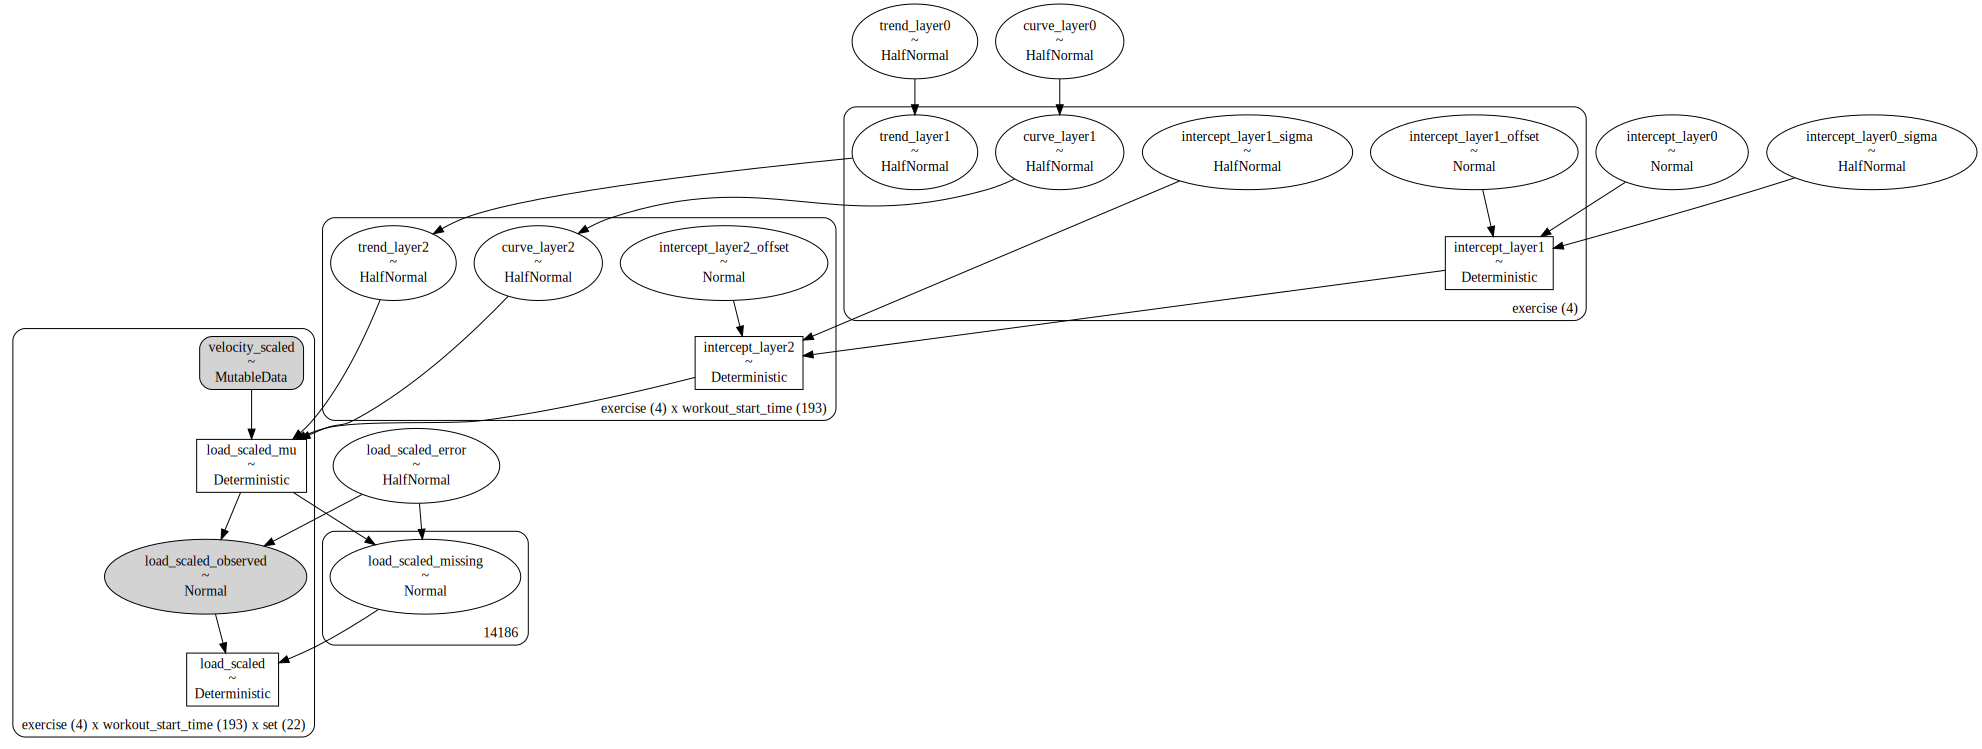

time: 1.69 s (started: 2022-09-28 07:34:49 +00:00)


In [97]:
xr_model = build_xr_model(x_name = 'velocity_scaled',
                          y_name = 'load_scaled',
                          data = regr_data_xr)

In [56]:
xr_inference_data = sample(model = xr_model,
                           prior_pred = False,
                           post_pred = False,
                           draws = 1000,
                           tune = 1000,
                           chains = n_devices,
                           target_accept = 0.98)

Compiling...


IndexError: ignored

time: 10.2 s (started: 2022-09-28 07:08:48 +00:00)


In [ ]:
xr_inference_data

## Inference

### Define Model

In [ ]:
def build_model(velocity_scaled,
                load_scaled,
                session_exercise_id,
                session_id,
                coords,
                render_model = True):
    
    with pm.Model() as model:

        # Add coordinates
        model.add_coord('observation', coords['observation'], mutable = True)
        model.add_coord('exercise', coords['exercise'], mutable = False)
        model.add_coord('session', coords['session'], mutable = False)

        # Add inputs
        velocity_shared = pm.MutableData('velocity_scaled', velocity_scaled, dims = 'observation')
        #session_exercise_id = pm.MutableData('session_exercise_id', session_exercise_id, dims = 'session')
        session_id = pm.MutableData('session_id', session_id, dims = 'observation')

        # Global Parameters
        intercept_global = pm.Normal(name = 'intercept_global',
                                     mu = 0.0,
                                     sigma = 1.0)
        
        intercept_sigma_global = pm.HalfNormal(name = 'intercept_sigma_global',
                                               sigma = 1.0)
        
        slope_global = pm.HalfNormal(name = 'slope_global',
                                     sigma = 1.0)
        
        curve_global = pm.HalfNormal(name = 'curve_global',
                                     sigma = 1.0)
        
        error_global = pm.HalfNormal(name = 'error_global',
                                     sigma = 1.0)
        
        # Exercise Parameters
        intercept_offset_exercise = pm.Normal(name = 'intercept_offset_exercise',
                                              mu = 0.0,
                                              sigma = 1.0,
                                              dims = 'exercise')
        
        intercept_exercise = pm.Deterministic(name = 'intercept_exercise',
                                              var = intercept_global + intercept_sigma_global*intercept_offset_exercise,
                                              dims = 'exercise')
        
        intercept_sigma_exercise = pm.HalfNormal(name = 'intercept_sigma_exercise',
                                                 sigma = 1.0,
                                                 dims = 'exercise')
        
        slope_exercise = pm.HalfNormal(name = 'slope_exercise',
                                       sigma = slope_global,
                                       dims = 'exercise')
        
        curve_exercise = pm.HalfNormal(name = 'curve_exercise',
                                       sigma = curve_global,
                                       dims = 'exercise')
        '''
        error_exercise = pm.HalfNormal(name = 'error_exercise',
                                       sigma = error_global,
                                       dims = 'exercise')
        '''
        # Session Parameters
        intercept_offset_session = pm.Normal(name = 'intercept_offset_session',
                                             mu = 0.0,
                                             sigma = 1.0,
                                             dims = 'session')

        intercept_session = pm.Deterministic(name = 'intercept_session',
                                                var = (intercept_exercise[session_exercise_id]
                                                       + intercept_sigma_exercise[session_exercise_id]
                                                       * intercept_offset_session),
                                                dims = 'session')
        
        slope_session = pm.HalfNormal(name = 'slope_session',
                                      sigma = slope_exercise[session_exercise_id],
                                      dims = 'session')

        curve_session = pm.HalfNormal(name = 'curve_session',
                                      sigma = curve_exercise[session_exercise_id],
                                      dims = 'session')
        '''
        error_session = pm.HalfNormal(name = 'error_session',
                                      sigma = error_exercise[session_exercise_id],
                                      dims = 'session')
        '''
        # Final Parameters
        intercept = intercept_session[session_id]
        slope = slope_session[session_id]
        curve = curve_session[session_id]
        error = error_global#error_session[session_id]

        # Estimated Value
        load_mu = pm.Deterministic(name = 'load_mu',
                                   var = intercept - slope*velocity_shared - curve*velocity_shared**2,
                                   dims = 'observation'
                                   )

        # Likelihood
        load_likelihood = pm.Normal(name = 'load_estimate',
                                    mu = load_mu,
                                    sigma = error,
                                    observed = load_scaled,
                                    dims = 'observation'
                                    )
    
    if render_model:
        display(pm.model_to_graphviz(model))

    return model

time: 11.8 ms (started: 2022-09-24 13:19:14 +00:00)


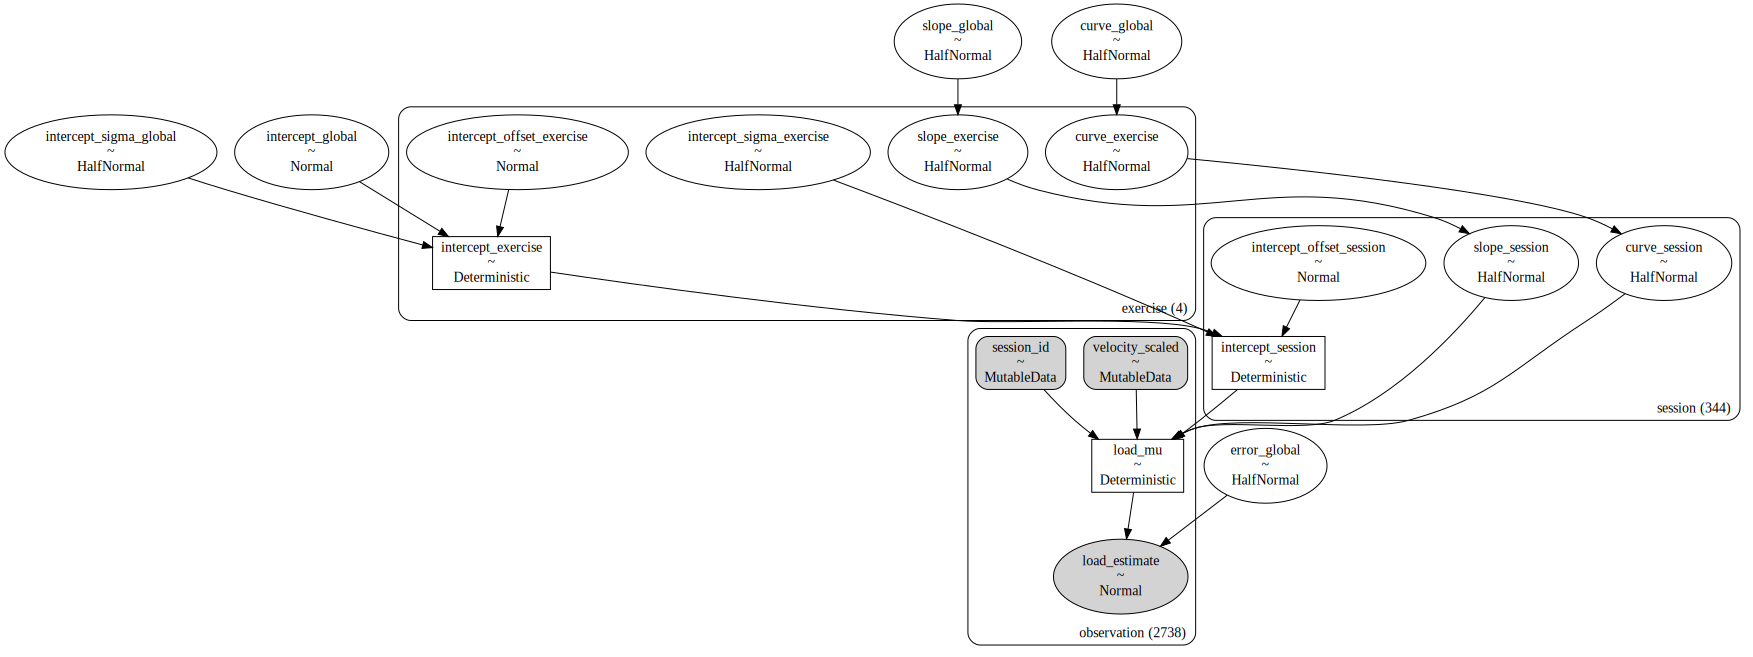

time: 2.79 s (started: 2022-09-24 13:19:14 +00:00)


In [ ]:
velocity_scaled = regr_data['velocity_scaled']
load_scaled = regr_data['load_scaled']
session_exercise_id = map_session_to_exercise_id
session_id = regr_data['session_id']

coords = {'observation': regr_data.index.values,
          'exercise': exercise_encoder.classes_,
          'session': regr_data['session_id'].unique()}

quadratic_model = build_model(velocity_scaled,
                              load_scaled,
                              session_exercise_id,
                              session_id,
                              coords)

### Sampling

#### Save inference data

In [ ]:
import traceback

try:
    inference_data_path = inference_data.to_netcdf('inference_data.nc')

except Exception:
    traceback.print_exc()

time: 38.3 ms (started: 2022-09-24 13:29:32 +00:00)


Traceback (most recent call last):
  File "<ipython-input-33-2edad8b68325>", line 4, in <module>
    inference_data_path = inference_data.to_netcdf('inference_data.nc')
  File "/usr/local/lib/python3.7/dist-packages/arviz/data/inference_data.py", line 427, in to_netcdf
    data.to_netcdf(filename, mode=mode, group=group, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/xarray/core/dataset.py", line 1912, in to_netcdf
    invalid_netcdf=invalid_netcdf,
  File "/usr/local/lib/python3.7/dist-packages/xarray/backends/api.py", line 1073, in to_netcdf
    dataset, store, writer, encoding=encoding, unlimited_dims=unlimited_dims
  File "/usr/local/lib/python3.7/dist-packages/xarray/backends/api.py", line 1119, in dump_to_store
    store.store(variables, attrs, check_encoding, writer, unlimited_dims=unlimited_dims)
  File "/usr/local/lib/python3.7/dist-packages/xarray/backends/common.py", line 266, in store
    variables, check_encoding_set, writer, unlimited_dims=unlimited_dims
  File 

### Trace Plots

In [ ]:
inference_summary = az.summary(inference_data,
                               var_names = ['~load_mu', '~session', '~sigma', '~offset', 'intercept', 'slope', 'curve', 'error'],
                               filter_vars = 'like',
                               hdi_prob = 0.9)
inference_summary

/usr/local/lib/python3.7/dist-packages/arviz/utils.py:137: UserWarning: Items starting with ~: ['load_mu', 'session', 'offset'] have not been found and will be ignored
  f"Items starting with ~: {not_found} have not been found and will be ignored"


KeyError: ignored

time: 334 ms (started: 2022-09-25 14:31:49 +00:00)


In [ ]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 20],
                  var_names = ['intercept_global', 'slope_global', 'curve_global', 'error_global'])

KeyError: ignored

time: 21.1 ms (started: 2022-09-25 14:32:12 +00:00)


In [ ]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  legend = True,
                  figsize = [15, 20],
                  var_names = ['intercept_exercise', 'slope_exercise', 'curve_exercise'])

In [ ]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 20],
                  var_names = ['intercept_session', 'slope_session', 'curve_session'])

### Prediction Plots

In [ ]:
def plot_predictions(inference_data,
                     session_id,
                     session_observation_ids,
                     ax,
                     group = 'posterior'):

    observation_coords = {'observation': session_observation_ids}

    velocity_observed = (inference_data.constant_data['velocity_scaled']
                                       .sel(observation_coords))

    load_observed = (inference_data.observed_data['load_estimate']
                                   .sel(observation_coords))

    if group == 'prior':
        load_field = 'load_mu'
        load_samples = (inference_data.prior[load_field]
                                      .sel(observation_coords))
        
    elif group == 'prior_predictive':
        load_field = 'load_mu'
        load_samples (inference_data.prior_predictive[load_field]
                                    .sel(observation_coords))
    
    elif group == 'posterior_predictive':
        load_field = 'load_estimate'
        load_samples = (inference_data.posterior_predictive[load_field]
                                      .sel(observation_coords))
        
    elif group == 'predictions':
        load_field = 'load_estimate'
        load_samples = (inference_data.predictions[load_field]
                                      .sel(observation_coords))
    
    else:
        load_field = 'load_mu'
        load_samples = (inference_data.posterior[load_field]
                                      .sel(observation_coords))

    load_estimate_median = load_samples.median(['chain', 'draw'])

    load_estimate_hdi = az.hdi(load_samples, hdi_prob = 0.9)[load_field]
    load_estimate_hdi_lower = load_estimate_hdi.sel({'hdi': 'lower'}, drop = True)
    load_estimate_hdi_upper = load_estimate_hdi.sel({'hdi': 'higher'}, drop = True)

    ax.plot(velocity_observed,
             load_observed,
             marker = '.',
             linestyle = '',
             label = 'Observed',
             zorder = 2)

    ax.plot(velocity_observed,
            load_estimate_median,
            label = 'Median',
            zorder = 1)

    ax.fill_between(x = velocity_observed,
                    y1 = load_estimate_hdi_lower,
                    y2 = load_estimate_hdi_upper,
                    alpha = 0.5,
                    color = '#ffcd3c',
                    label = '90% HDI',
                    zorder = 0)
    
    ax.set_title(f'{session_id} - {group}',
                 fontsize = 'large',
                 fontweight = 'bold')
    
    ax.set_xlabel('Velocity')
    ax.set_ylabel('Load')

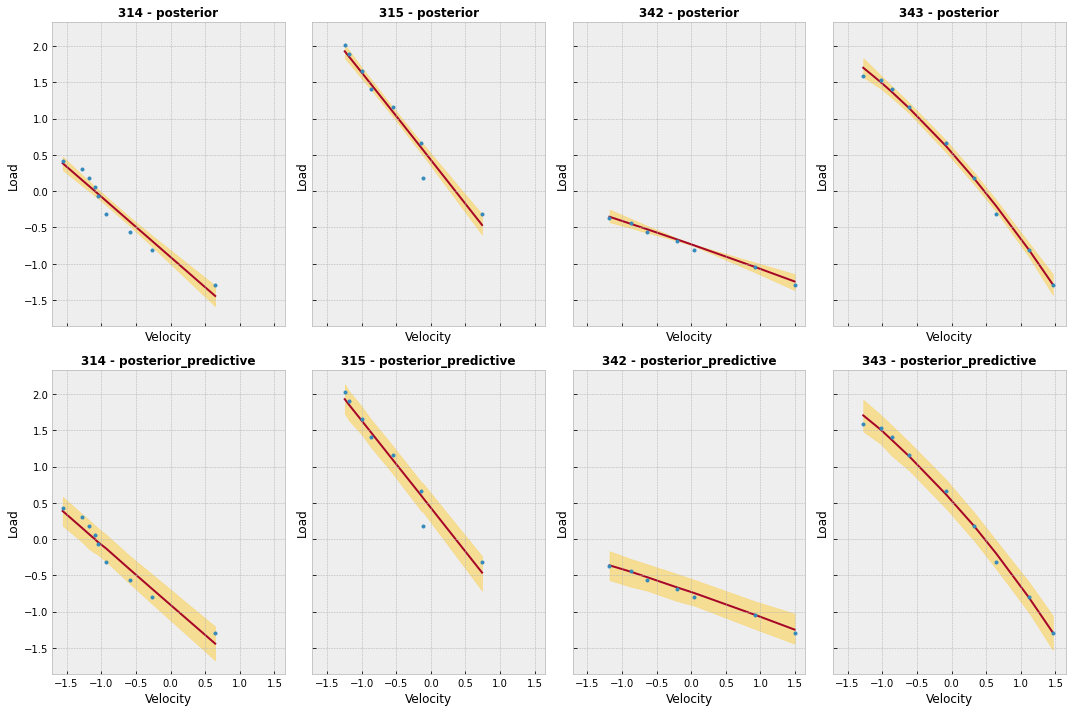

time: 2.59 s (started: 2022-09-24 13:30:23 +00:00)


In [ ]:
exercise_last_session_ids = regr_data.groupby(['exercise_id'])['session_id'].max().values
n_exercises = len(exercise_last_session_ids)

groups = ['posterior', 'posterior_predictive']
n_groups = len(groups)

fig, axes = plt.subplots(n_groups, n_exercises, figsize = (15, 10), sharex = True, sharey = True)

for i, cols in enumerate(axes):
    for j, cell in enumerate(cols):

        session_id = exercise_last_session_ids[j]

        filter = regr_data['session_id'] == session_id
        session_observation_ids = regr_data[filter].index.values

        plot_predictions(inference_data,
                         session_id,
                         session_observation_ids,
                         cell,
                         groups[i])
        
'''
fig.suptitle('Last Session Per Exercise',
             fontweight = 'bold',
             fontsize = 'x-large')
'''

fig.tight_layout()

plt.show()

In [ ]:
_ = az.plot_lm(idata = inference_data,
               y = 'load_estimate',
               x = 'velocity_scaled',
               y_model = 'load_mu',
               kind_pp = 'hdi')

## Prediction

### Generate Predictions

In [ ]:
def create_prediction_df(unique_session_df,
                         predict_velocity_series):
    unique_session_df = unique_session_df.copy()
    unique_session_df['_temp'] = True

    predict_velocity_df = pd.DataFrame(predict_velocity_series, columns = ['velocity_scaled'])
    predict_velocity_df['_temp'] = True

    df = (unique_session_df
          .merge(predict_velocity_df, on = ['_temp'])
          .drop('_temp', axis = 1))

    return df

time: 1.85 ms (started: 2022-09-22 21:17:16 +00:00)


In [ ]:
sessions = regr_data[['exercise', 'workout_start_time', 'exercise_id', 'session_id']].drop_duplicates()

velocity_start = 0.0
velocity_stop = np.ceil(regr_data['velocity'].max())
velocity = np.arange(velocity_start, velocity_stop*100 + 1)/100
velocity_scaled = velocity_scaler.transform(velocity.reshape(-1, 1)).flatten()

predict_velocities = pd.Series(velocity_scaled)

prediction_template = create_prediction_df(sessions, predict_velocities)
prediction_template

,exercise,workout_start_time,exercise_id,session_id,velocity_scaled
0,deadlift,2020-12-30 12:53:09,1,0,-1.933211
1,deadlift,2020-12-30 12:53:09,1,0,-1.901780
2,deadlift,2020-12-30 12:53:09,1,0,-1.870348
3,deadlift,2020-12-30 12:53:09,1,0,-1.838917
4,deadlift,2020-12-30 12:53:09,1,0,-1.807485
...,...,...,...,...,...
68737,squat,2022-09-22 20:16:19,3,341,4.227365
68738,squat,2022-09-22 20:16:19,3,341,4.258796
68739,squat,2022-09-22 20:16:19,3,341,4.290228
68740,squat,2022-09-22 20:16:19,3,341,4.321660


time: 51.6 ms (started: 2022-09-22 21:17:16 +00:00)


In [ ]:
prediction_template = prediction_template.merge(regr_data[['session_id', 'velocity_scaled', 'load_scaled']],
                                                how = 'left',
                                                on = ['session_id', 'velocity_scaled'])

prediction_template

,exercise,workout_start_time,exercise_id,session_id,velocity_scaled,load_scaled
0,deadlift,2020-12-30 12:53:09,1,0,-1.933211,NaN
1,deadlift,2020-12-30 12:53:09,1,0,-1.901780,NaN
2,deadlift,2020-12-30 12:53:09,1,0,-1.870348,NaN
3,deadlift,2020-12-30 12:53:09,1,0,-1.838917,NaN
4,deadlift,2020-12-30 12:53:09,1,0,-1.807485,NaN
...,...,...,...,...,...,...
68760,squat,2022-09-22 20:16:19,3,341,4.227365,NaN
68761,squat,2022-09-22 20:16:19,3,341,4.258796,NaN
68762,squat,2022-09-22 20:16:19,3,341,4.290228,NaN
68763,squat,2022-09-22 20:16:19,3,341,4.321660,NaN


time: 61.3 ms (started: 2022-09-22 21:17:16 +00:00)


In [ ]:
new_data = {'velocity_scaled': prediction_template['velocity_scaled'].values,
            'session_exercise_id': map_session_to_exercise_id,
            'session_id': prediction_template['session_id'].values}
            
new_coords = {'observation': prediction_template.index.values + len(regr_data)}

with quadratic_model:
    pm.set_data(new_data = new_data,
                coords = new_coords)
    
    predictions_idata = pm.sample_posterior_predictive(inference_data, predictions = True)

predictions_idata

Inference data with groups:
	> predictions
	> predictions_constant_data

time: 28.7 s (started: 2022-09-22 21:17:16 +00:00)


In [ ]:
predictions = inference_data.posterior_predictive['load_estimate']

time: 1.05 ms (started: 2022-09-22 21:21:48 +00:00)


In [ ]:
median = predictions.stack({'samples': ['chain', 'draw']}).median('samples')

time: 100 ms (started: 2022-09-22 21:21:51 +00:00)


In [ ]:
hdi = az.hdi(predictions, hdi_prob = 0.9)['load_estimate']
hdi_lower = hdi.sel({'hdi': 'lower'}, drop = True)
hdi_upper = hdi.sel({'hdi': 'higher'}, drop = True)

time: 503 ms (started: 2022-09-22 21:22:02 +00:00)


In [ ]:
prediction_df = regr_data.copy()

# Add predictions
prediction_df['load_scaled_median'] = median
prediction_df['load_scaled_lower'] = hdi_lower
prediction_df['load_scaled_upper'] = hdi_upper

# Inverse scale all values
prediction_df['velocity'] = velocity_scaler.inverse_transform(prediction_df['velocity_scaled'].values.reshape(-1, 1))
prediction_df['load'] = load_scaler.inverse_transform(prediction_df['load_scaled'].values.reshape(-1, 1))
prediction_df['load_median'] = load_scaler.inverse_transform(prediction_df['load_scaled_median'].values.reshape(-1, 1))
prediction_df['load_lower'] = load_scaler.inverse_transform(prediction_df['load_scaled_lower'].values.reshape(-1, 1))
prediction_df['load_upper'] = load_scaler.inverse_transform(prediction_df['load_scaled_upper'].values.reshape(-1, 1))

prediction_df

,exercise,workout_start_time,set,load,velocity,observation_weight,cycle_type,load_scaled,velocity_scaled,exercise_id,session_id,load_scaled_median,load_scaled_lower,load_scaled_upper,load_median,load_lower,load_upper
observation,,,,,,,,,,,,,,,,,
0,deadlift,2020-12-30 12:53:09,0,70.0,0.63,0.010152,n/a,-0.068759,0.046974,1,0,-0.110534,-2.284019,2.469263,68.299705,-20.161831,173.298310
1,deadlift,2020-12-30 12:53:09,1,80.0,0.50,0.015625,n/a,0.176940,-0.361636,1,0,0.139714,-2.217545,2.592804,78.484917,-17.456299,178.326483
2,deadlift,2020-12-30 12:53:09,2,90.0,0.49,0.019820,n/a,0.422638,-0.393067,1,0,0.168567,-2.151466,2.697107,79.659214,-14.766899,182.571641
3,deadlift,2020-12-30 12:53:09,3,100.0,0.64,0.019195,n/a,0.668336,0.078406,1,0,-0.151023,-2.490241,2.257592,66.651790,-28.555123,164.683237
4,deadlift,2020-12-30 12:53:09,4,110.0,0.48,0.031250,n/a,0.914035,-0.424499,1,0,0.174159,-2.330387,2.588012,79.886823,-22.049011,178.131437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,squat,2022-09-22 20:16:19,3,80.0,0.67,0.018346,YOLO,0.176940,0.172700,3,341,-0.298362,-2.743756,1.999798,60.655058,-38.873277,154.190919
2718,squat,2022-09-22 20:16:19,4,100.0,0.53,0.038673,YOLO,0.668336,-0.267341,3,341,-0.011304,-2.451828,2.434826,72.338400,-26.991695,171.896695
2719,squat,2022-09-22 20:16:19,5,120.0,0.39,0.096317,YOLO,1.159733,-0.707382,3,341,0.224860,-2.320772,2.894669,81.950365,-21.657704,190.612460


time: 39.5 ms (started: 2022-09-22 21:22:05 +00:00)


### Plot Last Sessions

In [ ]:
def plot_session(df, session_id, ax):
    filter = (df['session_id'] == session_id)# & (df['load_scaled_median'] >= 0)
    data = df[filter]

    auc = sklearn.metrics.auc(data['velocity_scaled'], data['load_scaled_median'])

    zero_velocity_load = data['load_scaled_median'].max()
    zero_velocity_load_lower = data['load_scaled_lower'].max()
    zero_velocity_load_upper = data['load_scaled_upper'].max()

    zero_load_velocity = data['velocity_scaled'].max()

    exercise = data['exercise'].values[0]
    workout_time = pd.to_datetime(data['workout_start_time'].values[0]).strftime('%Y-%m-%d')

    ax.plot('velocity_scaled',
            'load_scaled',
            marker = 'o',
            linestyle = '',
            label = 'Observed',
            zorder = 2,
            data = data)
    
    ax.plot('velocity_scaled',
            'load_scaled_median',
            label = 'Median',
            zorder = 1,
            data = data)

    ax.fill_between(x = 'velocity_scaled',
                    y1 = 'load_scaled_lower',
                    y2 = 'load_scaled_upper',
                    alpha = 0.5,
                    color = '#ffcd3c',
                    label = '90% HDI',
                    zorder = 0,
                    data = data)

    ax.set_title(f'{exercise.title()}\n{workout_time}',
                 fontsize = 'large',
                 fontweight = 'bold')
    
    ax.annotate(f'Zero Velocity Load: {zero_velocity_load:.0f} [{zero_velocity_load_lower:.0f}-{zero_velocity_load_upper:.0f}] kg\nZero Load Velocity: {zero_load_velocity:.2f} m/s\nArea Under Curve: {auc:.0f}',
                xy = [0.9855, 0.865],
                xycoords = 'axes fraction',
                horizontalalignment = 'right',
                verticalalignment = 'top',
                bbox = {'boxstyle': 'round',
                        'edgecolor': '#bcbcbc',
                        'facecolor': '#eeeeee'})
    
    ax.legend()
    
    ax.set_xlabel('Velocity')
    ax.set_ylabel('Load')

time: 3.34 ms (started: 2022-09-22 21:17:57 +00:00)


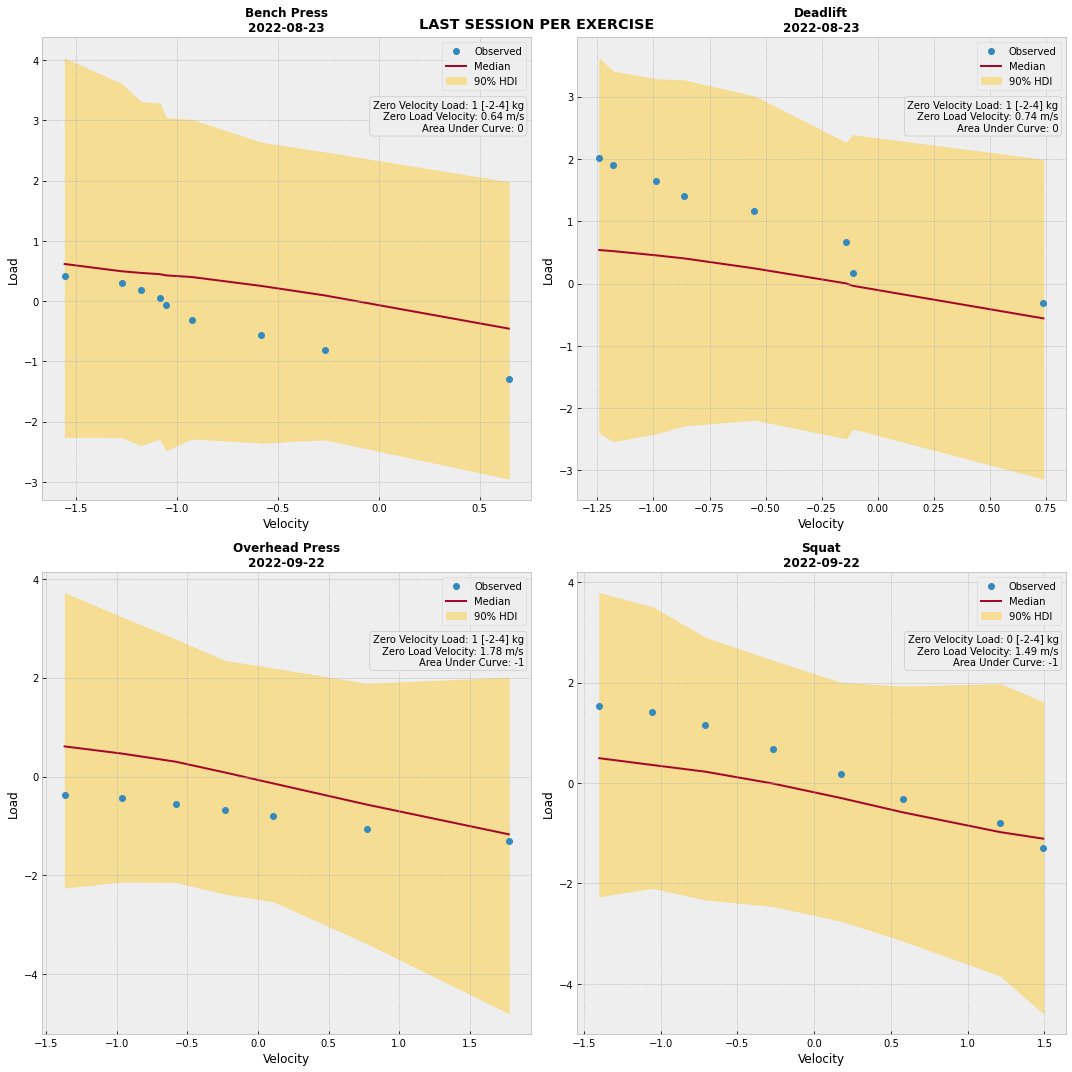

time: 955 ms (started: 2022-09-22 21:22:10 +00:00)


In [ ]:
exercise_last_session_ids = regr_data.groupby(['exercise_id'])['session_id'].max().values
n_exercises = len(exercise_last_session_ids)

n_cols = 1 if n_exercises == 1 else 2
n_rows = 1 if n_exercises <= 2 else  np.ceil(n_exercises/2).astype(int)

fig, axes = plt.subplots(n_cols, n_rows, figsize = (15, 15))

axes = np.array([axes])
axes = axes.flatten()

for i in np.arange(n_exercises):
    plot_session(prediction_df, exercise_last_session_ids[i], axes[i])

fig.suptitle('LAST SESSION PER EXERCISE',
             fontweight = 'bold',
             fontsize = 'x-large')

fig.tight_layout()

plt.show()

## 3D Hierarchical Model

In [91]:
# Create xarray with test data
coords = {'exercise': ['Squat', 'Overhead Press', 'Deadlift'],
          'date': ['2020-02-24', '2020-02-26', '2020-03-21', '2020-03-25', '2020-04-06', '2020-07-25', '2020-08-10'],
          'observation': [1, 2, 3, 4, 5, 6]}

dims = list(coords.keys())

velocities = np.array([[[1.198, 1.042, 0.875, 0.735, 0.574, 0.552],
                        [1.261, 0.993, 0.857, 0.828, 0.624, 0.599],
                        [1.224, 1.028, 0.990, 0.742, 0.595, 0.427],
                        [1.112, 0.999, 0.865, 0.751, 0.607, 0.404],
                        [1.157, 1.010, 0.849, 0.716, 0.593, 0.536],
                        [1.179, 1.060, 0.898, 0.783, 0.615, 0.501],
                        [1.209, 1.192, 0.979, 1.025, 0.875, 0.887]],
                       
                       [[0.911, 0.933, 0.779, 0.629, 0.528, 0.409],
                        [1.004, 0.863, 0.770, 0.611, 0.511, 0.376],
                        [0.980, 0.828, 0.766, 0.611, 0.529, 0.349],
                        [1.024, 0.933, 0.841, 0.734, 0.551, 0.287],
                        [0.985, 0.852, 0.599, 0.522, 0.313, 0.234],
                        [0.996, 0.763, 0.758, 0.542, 0.463, 0.378],
                        [1.066, 0.915, 0.786, 0.686, 0.565, 0.429]],
              
                       [[0.654, 1.004, 0.727, 0.483, np.nan, np.nan],
                        [0.885, 0.738, 0.577, 0.495, np.nan, np.nan],
                        [0.749, 0.695, 0.539, 0.461, 0.395, np.nan],
                        [0.801, 0.548, 0.404, 0.424, 0.337, np.nan],
                        [0.770, 0.642, 0.602, 0.493, 0.394, np.nan],
                        [0.766, 0.545, 0.426, 0.431, 0.349, 0.329],
                        [0.787, 0.640, 0.480, 0.401, 0.395, 0.304]]])

loads = np.array([[[20.0,  40.0,  60.0,  80.0, 100.0, 110.0],
                   [20.0,  40.0,  60.0,  80.0, 100.0, 110.0],
                   [20.0,  40.0,  60.0,  80.0, 100.0, 117.5],
                   [20.0,  40.0,  60.0,  80.0, 100.0, 115.0],
                   [20.0,  40.0,  60.0,  80.0, 100.0, 110.0],
                   [20.0,  40.0,  60.0,  80.0, 100.0, 110.0],
                   [20.0,  30.0,  40.0,  50.0,  60.0,  70.0]],
         
                  [[20.0,  25.0,  30.0,  35.0,  40.0,  45.0],
                   [20.0,  25.0,  30.0,  35.0,  40.0,  45.0],
                   [20.0,  25.0,  30.0,  35.0,  40.0,  45.0],
                   [20.0,  25.0,  30.0,  35.0,  40.0,  45.0],
                   [20.0,  30.0,  40.0,  45.0,  50.0,  52.5],
                   [20.0,  30.0,  35.0,  40.0,  42.5,  45.0],
                   [20.0,  25.0,  30.0,  35.0,  40.0,  45.0]],
         
                  [[60.0,  80.0, 100.0, 120.0, np.nan, np.nan],
                   [60.0,  80.0, 100.0, 120.0, np.nan, np.nan],
                   [60.0,  80.0, 100.0, 120.0, 127.5, np.nan],
                   [60.0, 100.0, 120.0, 125.0, 140.0, np.nan],
                   [60.0,  80.0, 100.0, 120.0, 130.0, np.nan],
                   [60.0, 100.0, 120.0, 125.0, 130.0, 132.5],
                   [70.0,  90.0, 120.0, 135.0, 140.0, 150.0]]])

dataset = xr.Dataset({'velocity': (dims, velocities),
                      'load': (dims, loads)},
                     coords = coords)

dataset['velocity_std'] = (dataset['velocity'] - dataset['velocity'].mean())/dataset['velocity'].std()
dataset['load_std'] = (dataset['load'] - dataset['load'].mean())/dataset['load'].std()

dataset

<xarray.Dataset>
Dimensions:       (exercise: 3, date: 7, observation: 6)
Coordinates:
  * exercise      (exercise) <U14 'Squat' 'Overhead Press' 'Deadlift'
  * date          (date) <U10 '2020-02-24' '2020-02-26' ... '2020-08-10'
  * observation   (observation) int64 1 2 3 4 5 6
Data variables:
    velocity      (exercise, date, observation) float64 1.198 1.042 ... 0.304
    load          (exercise, date, observation) float64 20.0 40.0 ... 150.0
    velocity_std  (exercise, date, observation) float64 1.976 1.347 ... -1.627
    load_std      (exercise, date, observation) float64 -1.222 -0.6838 ... 2.278

time: 43.3 ms (started: 2022-09-28 07:32:56 +00:00)


In [112]:
# Create PyMC
n_exercises = regr_data_xr.dims['exercise']
n_dates = regr_data_xr.dims['workout_start_time']
n_observations = regr_data_xr.dims['set']

exercise_date_idx = [[i]*n_dates for i in np.arange(n_exercises)]
exercise_idx = [[[i]*n_observations for j in np.arange(n_dates)] for i in np.arange(n_exercises)]
date_idx = [[[j]*n_observations for j in np.arange(n_dates)] for i in np.arange(n_exercises)]

velocity = regr_data_xr['velocity_scaled']
load = regr_data_xr['load_scaled']

with pm.Model(coords = coords) as model:
    # Inputs
    velocity_obs = pm.MutableData('velocity', velocity, dims = dims)
    velocity_impute = pm.Normal('velocity_impute',
                                mu = 0.0,
                                sigma = 1.0,
                                observed = velocity_obs,
                                dims = dims)

    # Global parameters
    global_intercept = pm.Normal('global_intercept', mu = 0, sigma = 1)
    global_intercept_sd = pm.Exponential('global_intercept_sd', lam = 1)

    global_slope = pm.Normal('global_slope', mu = 0, sigma = 1)
    global_slope_sd = pm.Exponential('global_slope_sd', lam = 1)

    # Exercise parameters
    exercise_intercept = pm.Normal('exercise_intercept', mu = global_intercept, sigma = global_intercept_sd, dims = 'exercise')
    exercise_intercept_sd = pm.Exponential('exercise_intercept_sd', lam = 1, dims = 'exercise')

    exercise_slope = pm.Normal('exercise_slope', mu = global_slope, sigma = global_slope_sd, dims = 'exercise')
    exercise_slope_sd = pm.Exponential('exercise_slope_sd', lam = 1, dims = 'exercise')
    
    # Date parameters
    date_intercept = pm.Normal('date_intercept', mu = exercise_intercept[exercise_date_idx], sigma = exercise_intercept_sd[exercise_date_idx], dims = ['exercise', 'date'])
    date_slope = pm.Normal('date_slope', mu = exercise_slope[exercise_date_idx], sigma = exercise_slope_sd[exercise_date_idx], dims = ['exercise', 'date'])

    # Model error
    sigma = pm.Exponential('sigma', lam = 1)

    # Expected value
    mu = date_intercept[exercise_idx, date_idx] + date_slope[exercise_idx, date_idx]*velocity_impute

    # Likelihood of observed values
    likelihood = pm.Normal('likelihood',
                           mu = mu,
                           sigma = sigma,
                           observed = load,
                           dims = dims)

ERROR:aesara.graph.opt:Optimization failure due to: constant_folding
ERROR:aesara.graph.opt:node: Assert{msg=Could not broadcast dimensions}(ScalarConstant{22}, TensorConstant{False})
ERROR:aesara.graph.opt:TRACEBACK:
ERROR:aesara.graph.opt:Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/aesara/graph/opt.py", line 1861, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/usr/local/lib/python3.7/dist-packages/aesara/graph/opt.py", line 1066, in transform
    return self.fn(fgraph, node)
  File "/usr/local/lib/python3.7/dist-packages/aesara/tensor/basic_opt.py", line 2785, in constant_folding
    required = thunk()
  File "/usr/local/lib/python3.7/dist-packages/aesara/graph/op.py", line 559, in rval
    r = p(n, [x[0] for x in i], o, params)
  File "/usr/local/lib/python3.7/dist-packages/aesara/raise_op.py", line 96, in perform
    raise self.exc_type(self.msg)
AssertionError: Could not broadcast dimensions



AssertionError: ignored

time: 819 ms (started: 2022-09-28 07:43:57 +00:00)


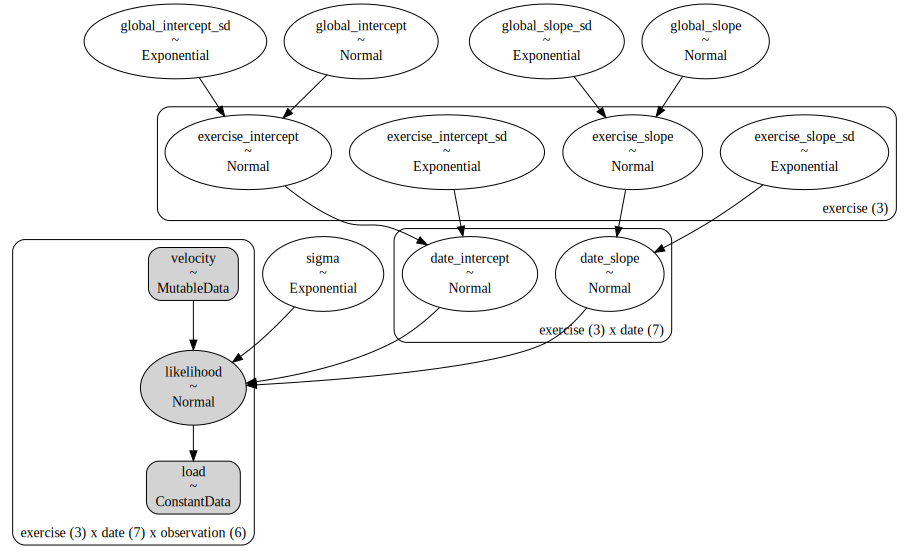

time: 122 ms (started: 2022-09-28 07:37:27 +00:00)


In [102]:
pm.model_to_graphviz(model)

In [100]:
three_dee_idata = pm.sample(model = model)

IndexError: ignored

time: 2.82 s (started: 2022-09-28 07:36:55 +00:00)
